# Single Particle Trajectory Analysis

In this script we are going to deeply analyse the single particle trajectory. The reason to perform this analysis is the observation of different jumping times for single particle in BASEP system.

###  Imports

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spo

import pims
import pint

from tqdm import tqdm_notebook as prog_bar

import support as sp

idx = pd.IndexSlice
%matplotlib inline

%load_ext autoreload
%autoreload 2

To proceed with the analysis, it is going to be loaded the index file, where the experiment parameters and the files are related.

Then, we are going to keep only the data related with one particle tests.

In [2]:
directory = r"Z:\BASEP\Datasets\Test_u0_cte"
trj_directory = r"Z:\BASEP\Datasets\Test_u0_cte\Trajectories" #Directory of trajectories

In [3]:
index = pd.read_csv(directory+'\\'+"index.dat", sep="\t", index_col = [0,1])
index.head()

Filename  omega  radius  wavelength
sigma N_particles                                            
0.98  27.0         Test20_20190617   0.72   17.43        4.18
      26.0         Test21_20190617   0.72   17.43        4.18
      23.0         Test22_20190617   0.72   17.43        4.18
      20.0         Test23_20190617   0.72   17.43        4.18
      17.0         Test24_20190617   0.72   17.43        4.18

In [4]:
trj_df = pd.DataFrame()

for s, id_sub in index.groupby("sigma"):
    
    filename = trj_directory+r"\Trajectory_"+index.loc[idx[s,1], "Filename"]
    
    trj = sp.trjLoading(filename+".dat")
    trj = sp.movementAnalyser(trj, index.loc[idx[s,1],"omega"])
    trj = trj.reset_index()
    trj["sigma"] = [s]*len(trj)
    
    trj_df = trj_df.append(trj)

trj_df = trj_df.set_index(["sigma", "frame", "particle"])
trj_df.head()

x           y      time           r     theta  \
sigma frame particle                                                          
0.62  0     0         58.464278 -140.215622  0.000000  151.916070 -1.175755   
      1     0         59.631098 -140.294721  0.016999  152.441715 -1.168890   
      2     0         59.775490 -140.327788  0.033999  152.528677 -1.168104   
      3     0         60.842977 -139.845439  0.050000  152.507753 -1.160425   
      4     0         60.988834 -139.698569  0.066999  152.431388 -1.159163   

                      theta_unwrap  theta_dot  theta_prime  \
sigma frame particle                                         
0.62  0     0            -1.175755        NaN     5.107430   
      1     0            -1.168890   0.403844     5.106475   
      2     0            -1.168104   0.046260     5.099442   
      3     0            -1.160425   0.479943     5.099761   
      4     0            -1.159163   0.074226     5.093203   

                      theta_prime_unwrap  theta_dot_prime  
sigma frame particle                                       
0.62  0     0                   5.107430              NaN  
      1     0                   5.106475        -0.056156  
      2     0                   5.099442        -0.413740  
      3     0                   5.099761         0.019943  
      4     0                   5.093203        -0.385774

In [5]:
#Select the desired sigma to analyse

sigma = 0.9
trj = trj_df.loc[idx[sigma,:,:],:].reset_index(level=["sigma","particle"],drop=True)
trj.head()

,x,y,time,r,theta,theta_unwrap,theta_dot,theta_prime,theta_prime_unwrap,theta_dot_prime
frame,,,,,,,,,,
0,51.395260,-91.117344,0.000,104.612825,-1.057226,-1.057226,NaN,5.225959,5.225959,NaN
1,51.834977,-91.300908,0.017,104.989145,-1.054437,-1.054437,0.164054,5.217528,5.217528,-0.495946
2,52.103012,-91.229328,0.034,105.059574,-1.051882,-1.051882,0.150298,5.208863,5.208863,-0.509702
3,52.736724,-91.131723,0.050,105.290802,-1.046196,-1.046196,0.355388,5.203990,5.203990,-0.304612
4,53.095915,-90.598589,0.067,105.010859,-1.040692,-1.040692,0.323728,5.198273,5.198273,-0.336272


In [6]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

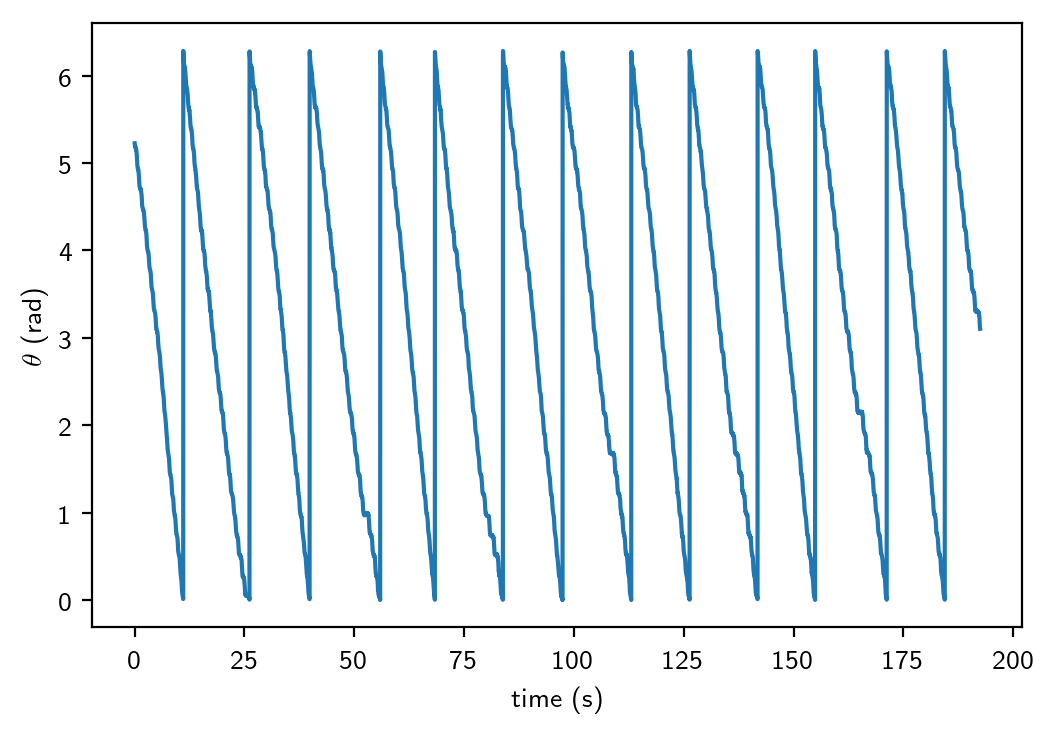

In [7]:
plt.plot(trj.time, trj.theta_prime)

# plt.xlim([0,5])
# plt.ylim([5,6.4])

plt.xlabel(r"time (s)")
plt.ylabel(r"$\theta$ (rad)");

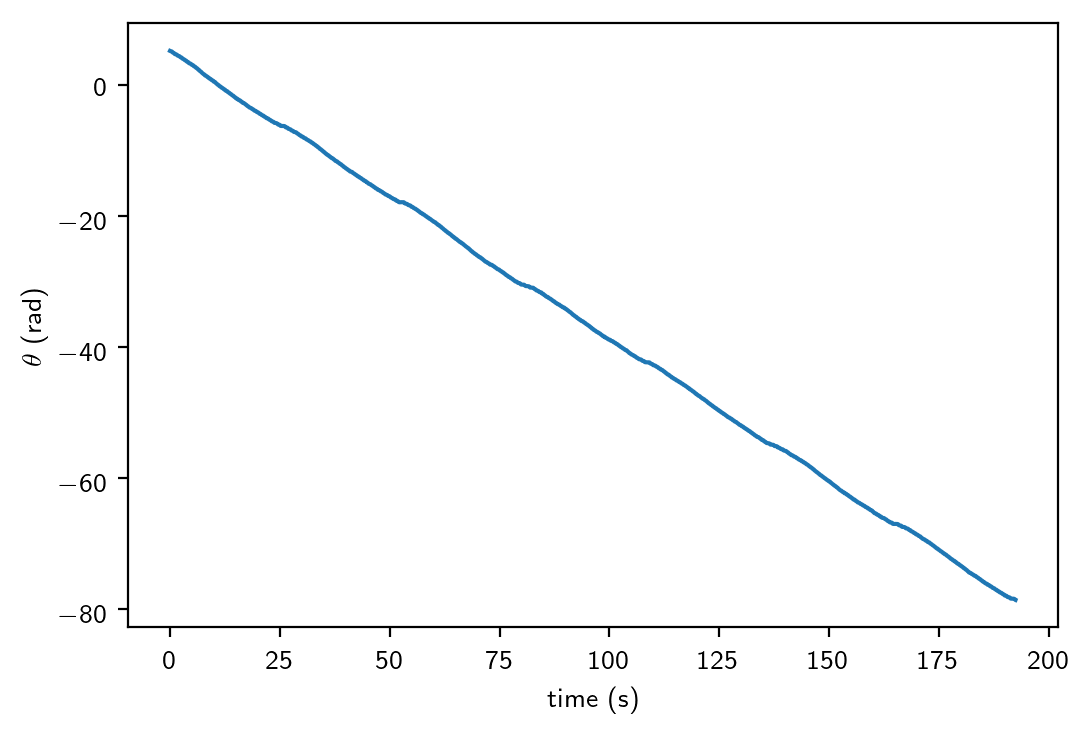

In [8]:
plt.plot(trj.time, trj.theta_prime_unwrap)

# plt.xlim([0,5])
# plt.ylim([-2,0.5])

plt.xlabel(r"time (s)")
plt.ylabel(r"$\theta$ (rad)");

In [9]:
deltat = []
delta_theta = 0.2

ref_frame = 0

for f in trj.index.get_level_values("frame").values:
    
    if round(abs(trj.loc[f, "theta_prime_unwrap"]-trj.loc[ref_frame, "theta_prime_unwrap"]),1)==delta_theta:
        deltat.append(trj.loc[f, "time"]-trj.loc[ref_frame, "time"])
        ref_frame = f

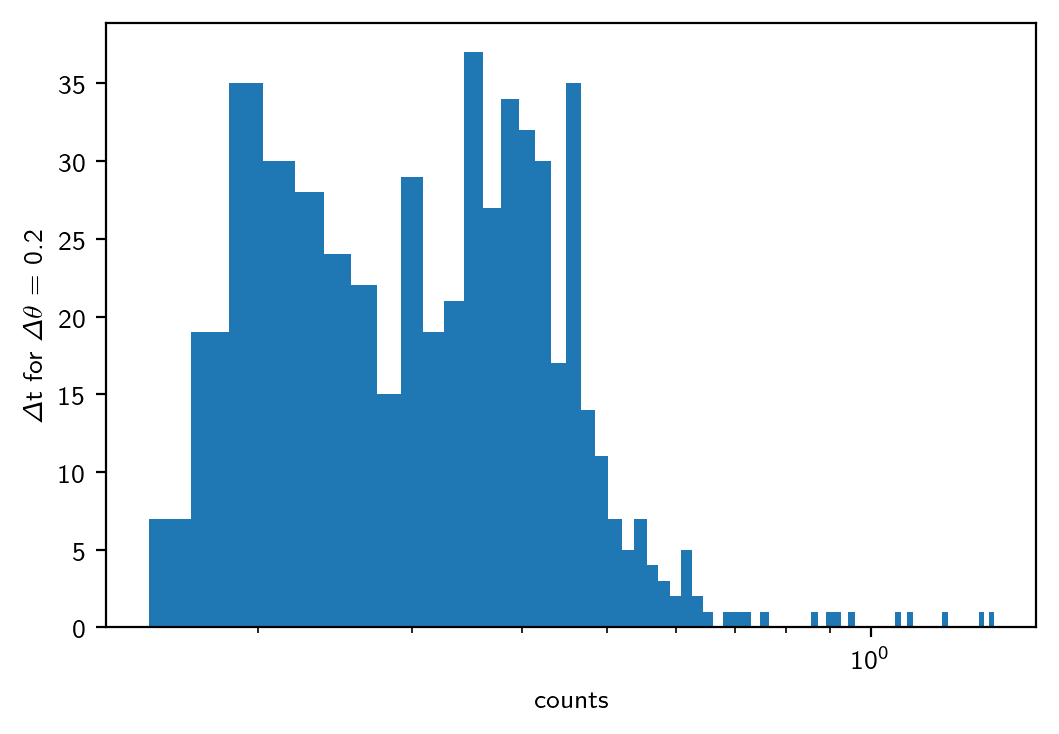

In [17]:
plt.hist(deltat,bins=70);
plt.xlabel("counts")
plt.xscale('log')
plt.ylabel(r"$\Delta$t for $\Delta \theta$ = {0}".format(delta_theta));
#plt.ylim([0,10]);